<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [105]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import imageio
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import utils
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import ResNet50
from PIL import Image as pil_image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import np_utils
from keras import regularizers

VGG16

## Part 2: Image Classifier

We will use VGG16 model to obtain a vector representation of the model

setting-up the parameters for image loader

In [71]:
img_width, img_height = 224, 224
path_train_images = r'/content/drive/MyDrive/dataset/train/images'   
path_test_images =  r'/content/drive/MyDrive/dataset/test/images'
path_dataset = r'/content/drive/MyDrive/dataset'
nb_train_samples = 532
nb_validation_samples = 380
epochs = 50
batch_size = 32


In [72]:
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)


In [73]:
im_generator = ImageDataGenerator()

In [74]:
train_df = im_generator.flow_from_directory(
  path_train_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )



Found 532 images belonging to 19 classes.


In [75]:
val_df = im_generator.flow_from_directory(
  path_test_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 380 images belonging to 19 classes.


In [76]:
tags = train_df.labels
print(f'tags are: {tags} \n and length of tags is: {len(tags)}')

tags are: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 1

In [77]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print(model_vgg16_conv.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
model_vgg16_conv.trainable = False
print(model_vgg16_conv.summary())
# model_vgg16_conv = Model(inputs=model_vgg16_conv.input, outputs=model_vgg16_conv.get_layer('fc2').output)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [106]:
model_resnet = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
model_resnet.trainable = False
model_resnet.summary()

115269632/115263384 [==============================] - 1s 0us/step
Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
__________________

In [107]:
X_train = model_resnet.predict(train_df, batch_size=batch_size)

In [108]:
X_test = model_resnet.predict(val_df, batch_size=batch_size)

In [ ]:
# X_train.to_csv(r'/content/drive/MyDrive/dataset/train/X_train.csv', index=False)
# X_test.to_csv(r'/content/drive/MyDrive/dataset/test/X_test.csv', index=False )

AttributeError: ignored

In [ ]:
# X_train = pd.read_csv('/content/drive/MyDrive/dataset/train/X_train.csv')
# X_test = pd.read_csv('/content/drive/MyDrive/dataset/test/X_test.csv')
# X_test

,vectors,tags
0,[0. 2.4787788 2.431244 ... 0. 3...,aeroplane
1,[0. 0. 5.791051 ... 0. 0. ...,aeroplane
2,[0. 0.49636486 3.15727 ... 0.447276...,aeroplane
3,[0. 0. 6.534189 ... 0. 0. ...,aeroplane
4,[0. 0. 5.223525 ... 0. 0. ...,aeroplane
...,...,...
375,[3.6616554 0. 0. ... 0. 0...,tvmonitor
376,[2.498087 0. 0. ... 0. 0. ...,tvmonitor
377,[1.6543726 0. 0. ... 0. 0...,tvmonitor
378,[0. 0. 0. ... 0. 0...,tvmonitor


In [ ]:
# plt.figure(figsize=(15, 10))
# for im, lbl in train_df.take(1):
#   for i in range(4):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(im[i].numpy().astype("uint8"))
#     plt.title(tags[lbl[i]])
#     plt.axis("off")


AttributeError: ignored

<Figure size 1080x720 with 0 Axes>

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_df = validation_df.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )


In [ ]:
# normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_df))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


In [10]:
y_train = utils.to_categorical(train_df.labels)
y_test = utils.to_categorical(val_df.labels)

In [11]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [109]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=1e-3, momentum=0.9, decay=1e-3 / 25)
reg_hyp = 0
model = Sequential([
  # data_augmentation,
  # layers.experimental.preprocessing.Rescaling(1./255),
  layers.Flatten(),
  layers.Dense(512, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.6),
  BatchNormalization(),
  layers.Dense(256, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(256, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(64, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(19, activation='softmax')
])
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
history = model.fit(
  X_train,
  y_train,
  epochs=50,
  shuffle=True,
  validation_data=(X_test, y_test),
  batch_size=128 
)


Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 20.8154 - accuracy: 0.0685 - val_loss: 20.3275 - val_accuracy: 0.1947
Epoch 2/50
5/5 [==============================] - 5s 948ms/step - loss: 20.4289 - accuracy: 0.0998 - val_loss: 19.9960 - val_accuracy: 0.3053
Epoch 3/50
5/5 [==============================] - 5s 962ms/step - loss: 20.0988 - accuracy: 0.1411 - val_loss: 19.8050 - val_accuracy: 0.3711
Epoch 4/50
5/5 [==============================] - 5s 961ms/step - loss: 19.9422 - accuracy: 0.1921 - val_loss: 19.5161 - val_accuracy: 0.4237
Epoch 5/50
5/5 [==============================] - 5s 962ms/step - loss: 19.9931 - accuracy: 0.1925 - val_loss: 19.2792 - val_accuracy: 0.4605
Epoch 6/50
5/5 [==============================] - 5s 969ms/step - loss: 19.7059 - accuracy: 0.2276 - val_loss: 19.1147 - val_accuracy: 0.4895
Epoch 7/50
5/5 [==============================] - 5s 965ms/step - loss: 19.5174 - accuracy: 0.2426 - val_loss: 18.9786 - val_accuracy: 0.5053
Epoch 8/5

In [53]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)              

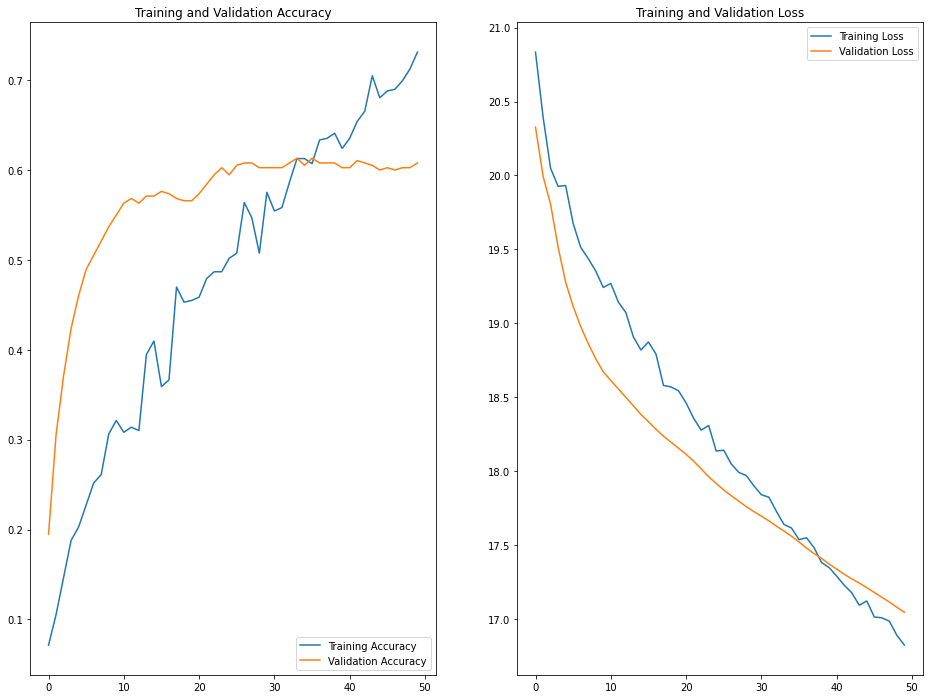

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs_range = range(epochs)


plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# model.fit_generator(
#         train_generator,
#         steps_per_epoch=532 // batch_size,
#         epochs=epochs,
#         validation_data=validation_generator,
#         validation_steps=380 // batch_size)
# model.save_weights('first_try.h5') 

Reading the images and format them into a dataframe

In [ ]:
# function for reading images into a pandas dataframe
def read_data_into_df(filespath, num_files):
  levels = 0
  default_size = 224
  im_list = np.zeros(shape=(num_files, 224, 224, 3))
  for roots, dirnames, filenames in os.walk(filespath):
    # if levels == 0:
    #   images = np.zeros(shape=(19, 224, 224, 3))
    for fn in filenames:
      im_full_path = os.path.join(roots, fn)
      print(im_full_path)
      # temp=pd.read_csv(txtfile_full_path,sep="\\n", header=None, error_bad_lines=False)
      # print('shape of temp: ', temp.shape)
      # txt_list.append(temp.values)
      # -------------------- another approach to read txt files
      im = pil_image.open(im_full_path)
      print('info of im: ', im.info)
      im_resized = im.resize((default_size, default_size), pil_image.NEAREST)
      im_arr = image.img_to_array(im_resized)
      im_expand = np.expand_dims(im_arr, axis=0)
      im_list[levels,:, :, :] = im_expand
      levels+=1
    root = os.path.split(roots) 
    root = root[1]
    print(root)
    # if levels != 0:
    # images[levels, :, :, :] = im_list
  inputs = preprocess_input(im_list)
  image_features = model_rep.predict(inputs)
  return image_features


In [ ]:
path_train_sentences = r'/content/drive/MyDrive/dataset/train/images'   
path_test_sentences =  r'/content/drive/MyDrive/dataset/test/images'   
train = read_data_into_df(path_train_sentences, 532)
test = read_data_into_df(path_test_sentences, 380)

images
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001227.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001380.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001448.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (150, 150), 'jfif_unit': 1, 'jfif_density': (150, 150)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001468.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001801.jpg
info of im:  {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72)}
/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001971.jpg
info of im:  {'jfif

In [ ]:
for i in test:
  print(f'index i is: {len(i)}')
len(test)

index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 4096
index i is: 40

380

In [ ]:
#  IGNORE _______________ For TESTING
# images = np.zeros(shape=(1, 224, 224, 3))
# im_list = []
# im_full_path = r'/content/drive/MyDrive/dataset/train/images/aeroplane/2008_001227.jpg'
# im = pil_image.open(im_full_path)
# print('info of im: ', im.info)
# im_resized = im.resize((224, 224), pil_image.NEAREST)
# im_arr = image.img_to_array(im_resized)
# im_expand = np.expand_dims(im_arr, axis=0)
# im_list.append(im_expand)
# # print(im_list)
# # print(len(im_list))
# images[0, :, :, :] = im_expand
# input = preprocess_input(images)
# input
# # print(im_expand)
# # print(im_list.)

### Dataframe inspection, evaluation and preprocessing


The dataframes don't have any null values so we are good to go on that aspect  
What remains is to add tags to the captions of each type

In [ ]:
# from google.colab.patches import cv2_imshow
# for i in train['chair']:
#   cv2_imshow(i)

In [ ]:
def make_tabular_df(df, eos):
  level = 0
  end_of_slice = 0
  tag_num = 0
  tags = []
  for roots, dirnames, filenames in os.walk(path_train_sentences):
    if level == 0:
      tags = dirnames
      # print(f"tags: {tags}")
      level += 1
  output = pd.DataFrame(columns=['vectors',  'tags'])
  for row in df:
    # print(tag_num)
    df=pd.DataFrame({"vectors": [row], "tags": tags[tag_num]})
    output=output.append(df)
    end_of_slice += 1
    if end_of_slice == eos:
      end_of_slice = 0
      tag_num += 1
  return output


In [ ]:
X_train = make_tabular_df(train, 28)
X_train.head(40)

,vectors,tags
0,"[0.0, 0.0, 0.0, 0.0, 3.3479023, 0.0, 0.0, 0.0,...",aeroplane
0,"[0.0, 0.0, 8.874906, 0.0, 0.0, 1.1840837, 0.18...",aeroplane
0,"[0.0, 0.0, 3.6079855, 0.0, 0.0, 0.0, 0.0, 0.0,...",aeroplane
0,"[0.0, 0.0, 4.127274, 0.0, 2.186235, 0.0, 0.0, ...",aeroplane
0,"[0.0, 1.4552373, 1.5524035, 2.8286853, 3.94783...",aeroplane
0,"[0.0, 0.0, 6.448868, 0.90400803, 0.08289868, 0...",aeroplane
0,"[0.0, 1.4599806, 0.0, 0.0, 0.0, 1.1290915, 0.5...",aeroplane
0,"[0.0, 0.0, 6.7299023, 0.0, 0.0, 1.3051215, 1.7...",aeroplane
0,"[0.0, 0.0, 4.738022, 0.68310475, 1.2823329, 0....",aeroplane
0,"[0.12104154, 0.7178468, 0.0, 0.23665011, 0.0, ...",aeroplane


In [ ]:
X_test = make_tabular_df(test, 20)
X_test['vectors']

0    [0.0, 2.4787788, 2.431244, 0.0, 0.0, 0.0, 2.80...
0    [0.0, 0.0, 5.791051, 0.30064175, 0.0, 0.0, 0.0...
0    [0.0, 0.49636486, 3.15727, 0.0, 1.8351302, 0.0...
0    [0.0, 0.0, 6.534189, 0.0, 0.42821068, 0.0, 1.3...
0    [0.0, 0.0, 5.223525, 0.0, 0.0, 2.6170971, 0.0,...
                           ...                        
0    [3.6616554, 0.0, 0.0, 0.0, 2.3967164, 0.0, 0.0...
0    [2.498087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.689...
0    [1.6543726, 0.0, 0.0, 0.0, 7.138142, 0.0, 0.0,...
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3555195,...
0    [0.0, 0.0, 0.0, 0.0, 2.0307298, 0.0, 0.3356555...
Name: vectors, Length: 380, dtype: object

We obtained the dataframes ready to go to next phase


In [ ]:
plt.figure(figsize=(24,20))
X_train.tags.value_counts().plot(kind='bar', color=['Blue', 'Red', 'Brown', 'Gray']);

We can confirm visually that our dataset is balanced

## Keras

In [ ]:
print(f"train size: {len(X_train)}")
print(f"test size: {len(X_test)}")

train size: 532
test size: 380


in both encoder and tokenizer we only fit on train for consistency

In [ ]:
le = LabelEncoder()
le.fit(X_train['tags'])
y_train = le.transform(X_train['tags'])
y_test = le.transform(X_test['tags'])

In [ ]:
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

shape of new y_train is: (532,)
shape of new y_test is: (380,)


Convert the enoded y_train and y_test to one-hot representation

In [ ]:
num_tags = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_tags)
y_test = utils.to_categorical(y_test, num_tags)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's set our hyperparameters  
we will adjust these later to, if possible, reach higher accuracy

In [ ]:
batch_size = 16
epochs = 12

Buliding the model

we have the model, train and test data prepared  
so let's train the model

In [ ]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train['vectors'].values

array([array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([0.      , 0.      , 8.874906, ..., 0.      , 0.      , 0.      ],
      dtype=float32),
       array([0.       , 0.       , 3.6079855, ..., 0.       , 0.       ,
       0.       ], dtype=float32),
       array([0.      , 0.      , 4.127274, ..., 0.      , 0.      , 0.      ],
      dtype=float32),
       array([0.        , 1.4552373 , 1.5524035 , ..., 0.23765668, 0.        ,
       0.        ], dtype=float32),
       array([0.       , 0.       , 6.448868 , ..., 1.1271995, 0.       ,
       0.       ], dtype=float32),
       array([0.       , 1.4599806, 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32),
       array([0.       , 0.       , 6.7299023, ..., 0.       , 0.       ,
       0.       ], dtype=float32),
       array([0.      , 0.      , 4.738022, ..., 3.530775, 0.      , 1.39113 ],
      dtype=float32),
       array([0.12104154, 0.7178468 , 0.        , ..., 1.1056347 , 2.168427  ,
    

In [ ]:
x_train = []
for index, row in X_train.iterrows():
  x_train.append(row['vectors'])
x_train

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.      , 0.      , 8.874906, ..., 0.      , 0.      , 0.      ],
       dtype=float32),
 array([0.       , 0.       , 3.6079855, ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 array([0.      , 0.      , 4.127274, ..., 0.      , 0.      , 0.      ],
       dtype=float32),
 array([0.        , 1.4552373 , 1.5524035 , ..., 0.23765668, 0.        ,
        0.        ], dtype=float32),
 array([0.       , 0.       , 6.448868 , ..., 1.1271995, 0.       ,
        0.       ], dtype=float32),
 array([0.       , 1.4599806, 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 array([0.       , 0.       , 6.7299023, ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 array([0.      , 0.      , 4.738022, ..., 3.530775, 0.      , 1.39113 ],
       dtype=float32),
 array([0.12104154, 0.7178468 , 0.        , ..., 1.1056347 , 2.168427  ,
        0.        ], dtype=float32),
 array([0.      , 0

In [ ]:
for i in x_train:
  print(len(i))

4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096


In [ ]:
len(x_train[10])

4096

In [ ]:
print(f'shape of new x_train is: {len(x_train)}')
print(f'shape of new x_test is: {X_test.shape}')
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

shape of new x_train is: 532
shape of new x_test is: (380, 2)
shape of new y_train is: (532, 19)
shape of new y_test is: (380, 19)


In [ ]:
model = Sequential([
    tf.keras.layers.Flatten(input_shape=(4096, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(19)
])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_split=0.1)

ValueError: ignored

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print(f'Test score:{score[0]}')
print(f'Test accuracy:{score[1]}')

In [ ]:
txt_lbls = le.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = txt_lbls[np.argmax(prediction)]
    print(X_test['captions'].iloc[i][:50], "...")
    print('Actual label:' + X_test['tags'].iloc[i])
    print("Predicted label: " + predicted_label + "\n")

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
y_sm = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_sm)):
    probs = y_sm[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=txt_lbls, title="Confusion matrix")
plt.show()